# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Fit to the signal energy region

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objectives:

   * ***Fit the signal energy region***

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Generate an experiment with a given number of signal events and a level of background compatible with the one estimated using the blind-data sample (in previous task).

   * Estimate the uncertainties in the numbe of evnets
   
### Notes

   * We are going to fit the selected events in the *erange* energy region to the three samples: $\beta\beta0\nu$, $^{214}$Bi and $^{208}$Tl.
   
   * We use an extended maximum likelihood fit of a composite PDF

## Main parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# list of the analisys selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, erange]
print('ana varnames  : ', varnames)
print('ana varranges : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, erange]
print('ref varnames  : ', refnames)
print('ref varranges : ', refranges)


ana varnames  :  ['num_tracks', 'blob2_E', 'E']
ana varranges :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7)]
ref varnames  :  ['num_tracks', 'E']
ref varranges :  [(1, 1.1), (2.4, 2.7)]


In [7]:
# number of  blind events
nevts_Bi = collpars.nevts_Bi
nevts_Tl = collpars.nevts_Tl
print('Number of bkg events in full data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(nevts_Bi, nevts_Tl))

Number of bkg events in full data : Bi = 1403.27, Tl = 20673.20.


## Access the data

In [8]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

mcs      = [mcbb, mcbi, mctl]
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$',r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


## Check method with a mc experiment

  * Generate a MC experiments with number of events compatible with estimated number of bkg events and a hipothetical number of signal events.
  
  * Fit the energy distribution of the selected events to the samples pdfs: bb, Bi. Tl
  
  * Do a profile scan to estimate the confidence interval and p0-value for this example
  
### Notes

  * There is an appendix with the code step by step.

### Exercises

  * Generate other experiments with different number of signal events to study the performance of the fit

In [9]:
def nevts_total(factor = 1.):
    nevts_Bi_RoI    = collpars.nevts_Bi_RoI
    eff_bb_RoI      = collpars.eff_bb_RoI
    nevts           = (factor * nevts_Bi_RoI / eff_bb_RoI, nevts_Bi, nevts_Tl)
    return np.array(nevts)

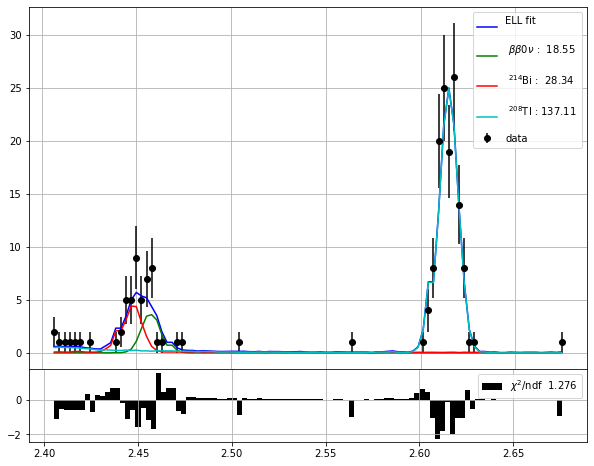

In [10]:
# set the number of events
# expected bkg events are estimated using the fit to the blind data
# consider the number of signal events a factor of the expected Bi events 
factor          = 1.
nevts           = nevts_total(factor)

# define the fit
fit             = fn.prepare_fit_ell(mcs, nevts, varnames, varranges, refnames, refranges)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mcs, nevts)

result, values, \
ell, nevts_est  = fit(mcdata)
nevts_est = result.x if result.success else nevts_exp

pltfn.plot_fit_ell(values, nevts_est, ell)

## Parameter uncertanties estimation

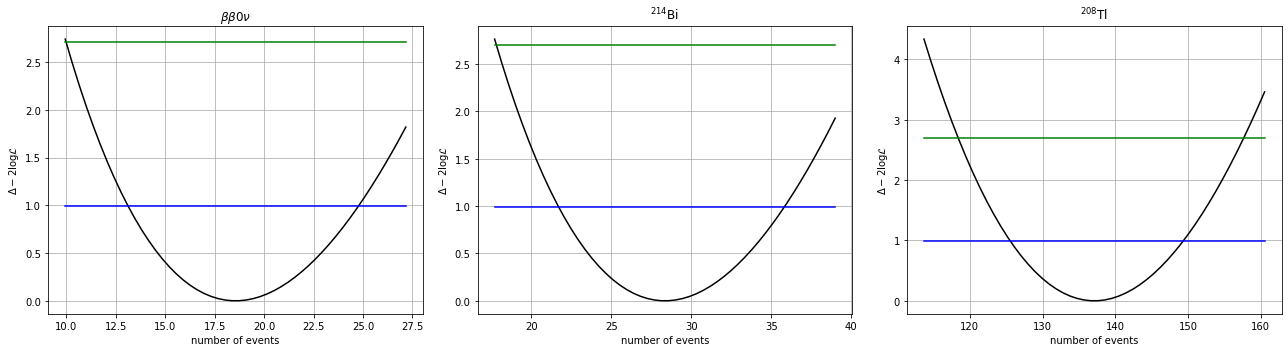

In [11]:
nis, tmus = fn.tmu_scan(values, result.x, ell, sizes = (2., 2., 2.))
pltfn.plot_tmu_scan(nis, tmus)

In [12]:
cl    = 0.68
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(tsamples[i], 100*cl, *ci))

Number of bb events CI at   68 % CL = (13.45, 24.71)
Number of Bi events CI at   68 % CL = (22.04, 35.51)
Number of Tl events CI at   68 % CL = (126.11, 149.05)


In [13]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(tsamples[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - result.x[i])))

Number of bb events CI at   68 % CL = 18.55  -5.10 + 6.15
Number of Bi events CI at   68 % CL = 28.34  -6.30 + 7.17
Number of Tl events CI at   68 % CL = 137.11  -10.99 +11.95


## Null hypothesis p-value calculation

In [14]:
q0 = efit.tmu(values, ell, result.x, 0.)
z0 = np.sqrt(q0)
p0 = 1 - stats.norm.cdf(z0)
#p0 = stats.chi2.sf(q0, 1)/2.
print('H0 p value {:1.2e}, {:4.2f} sigmas'.format(p0, z0))

H0 p value 4.42e-06, 4.44 sigmas


## Estimate the half-time

In [15]:
from collpars import exposure

nevts_bb_RoI = collpars.nevts_Bi_RoI
eff          = collpars.acc_bb * collpars.eff_bb_RoI
tau          = fn.half_life(nevts_bb_RoI, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb_RoI))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))

number of bb0nu events  : 21.751
exposure                : 1000.00 kg y
total signal efficiency :  0.410
bb0nu half-life         : 5.21e+25 y 


## Appendix: Step by step

Total number of events     : bb =  41.91,  Bi = 1403.27,  Tl = 20673.20, 
Expected number of events  : bb =  21.75,  Bi =  25.25,  Tl = 150.85, 
Fit success ?              : True
Estimated number of events : bb =  19.70,  Bi =  18.87,  Tl = 141.42, 


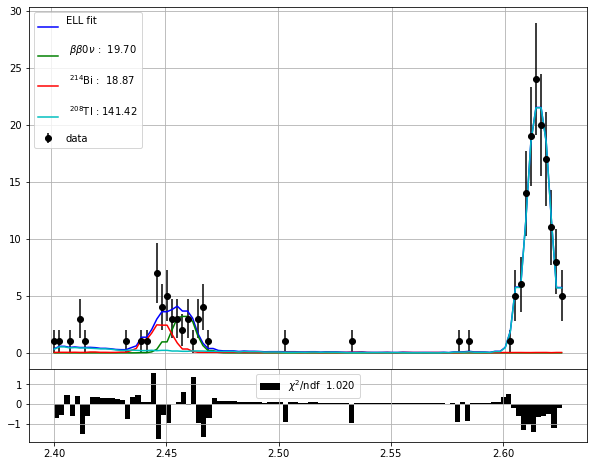

In [16]:
# set the number of events
# expected bkg events are estimated using the fit to the blind data
# consider the number of signal events a factor of the expected Bi events 
factor          = 1.
nevts           = nevts_total(factor)

# generate the ELL instace to fit the energy distribution to the energy distribution of the three mc samples
ell             = fn.get_ell(mcs, refnames, refranges)

# expected number of events for each mc sample
effs            = [ut.selection_efficiency(mc, varnames, varranges)[0] for mc in mcs]
nevts_exp       = effs * np.array(nevts)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mcs, nevts)

# select the data
datana          = ut.selection_sample(mcdata, varnames, varranges)

# fit the energy values of the data 
values          = datana['E'].values
result          = ell.best_estimate(values, *nevts_exp)
nevts_est       = result.x

# plot the results
pltfn.plot_fit_ell(values, nevts_est, ell)

# print out
print('Total number of events     :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts)])
print('Expected number of events  :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_exp)])

print('Fit success ?              :', result.success)
print('Estimated number of events :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_est)])

### Note: The evil is in the details

To compute the pdfs of the different samples, we do not apply the analysis selection, instead we use a reference selection.

As the blob-energy and the event energy are uncorrelated, we have used  the event energy distributions obtained before the blob-energy cut as templates for the PDFs. With this selection we have more mc events to better define the PDFs. If we have a large MC statistics we do not need this trick.
